In [78]:
##OCR of Hand-written Digits
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SZ = 20
bin_n = 16 #Number of bins

svm_params = dict( kernel_type = cv2.SVM_LINEAR,
                   svm_type = cv2.SVM_C_SVC,
                   C=2.67, gamma=5.383 )

affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=affine_flags)
    return img

def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    
    bins = np.int32(bin_n*ang/(2*np.pi))
    
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    return hist

In [79]:
img = cv2.imread('digits.png', 0)

cells = [np.hsplit(row,100) for row in np.vsplit(img, 50)]

train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells ]

deskewed = [ map(deskew, row) for row in train_cells ]
hogdata = [ map(hog, row) for row in deskewed ]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.float32(np.repeat(np.arange(10), 250)[:,np.newaxis])
                       
svm = cv2.SVM()
svm.train(trainData, responses, params=svm_params)
print responses
svm.save('svm_data.dat')

deskewed = [map(deskew,row) for row in test_cells]
hogdata = [map(hog,row) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict_all(testData)

#######   Check Accuracy   ########################
mask = result==responses
correct = np.count_nonzero(mask)
print 'Accuracy: ',correct*100.0/result.size

[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 9.]
 [ 9.]
 [ 9.]]
Accuracy:  93.8


Loading model from prueba.xml
0.0
1.0


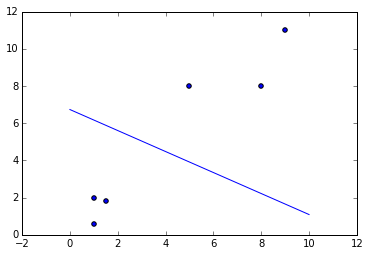

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.dom.minidom
%matplotlib inline

def load_model(path):
    print "Loading model from {}".format(path)
    model = xml.dom.minidom.parse(path)

    # TODO: handle multiple support vectors?
    weights = np.fromstring(model.getElementsByTagName("_")[0].childNodes[0].nodeValue, sep=" ")
    alpha = float(model.getElementsByTagName("alpha")[0].childNodes[0].nodeValue)
    rho = float(model.getElementsByTagName("rho")[0].childNodes[0].nodeValue)
    weights = weights * -alpha
    return weights, rho


x = [1,5, 1.5,8, 1,9]
y = [2, 8, 1.8, 8, 0.6, 11]

plt.scatter(x, y)

trainData = np.array([[1,2],
             [5,8],
             [1.5,1.8],
             [8,8],
             [1,0.6],
             [9,11]], dtype=np.float32)

responses = np.array([0.,1.,0.,1.,0.,1.], dtype=np.float32)


svm_params = dict( kernel_type = cv2.SVM_LINEAR,
                   svm_type = cv2.SVM_C_SVC,
                   C=2.67, gamma=5.383 )

clf = cv2.SVM()
clf.train(trainData, responses, params=svm_params)
clf.save('prueba.xml')
w,b = load_model('prueba.xml')

x = [0,10]
y = [(-w[0] * x[0] -b) / w[1], (-w[0] * x[1] -b) / w[1]]

plt.plot(x,y)


test1 = np.array([0.58,0.76], dtype=np.float32)
test2 = np.array([10.1,9.6], dtype=np.float32)
print clf.predict(test1)
print clf.predict(test2)

